<a href="https://colab.research.google.com/github/saotomryo/Use_VisionTransFormer/blob/main/Vision__Transfomer_with_Cross_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## トランスフォーマー等のインストールコンポーネントのインストール

In [1]:
!pip install transformers
!pip list | grep transformers
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

     |████████████████████████████████| 2.9 MB 7.0 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 636 kB 69.4 MB/s 
     |████████████████████████████████| 3.3 MB 60.4 MB/s 
     |████████████████████████████████| 895 kB 59.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
transformers                  4.11.3
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-2zylnj59
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-2zylnj59
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3879 sha256=67c1b0c8dacf92b2f3ddf8ef3177968d01189fcf8eda087af039dceae931c07f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hv9_e4n/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully bui

## 利用するパッケージのインポート

In [2]:
from PIL import Image
import os
from glob import glob

import pandas as pd
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from statistics import mean

import warmup_scheduler
from transformers import ViTFeatureExtractor, ViTModel

学習を行う対象フォルダ
へ移動

対象フォルダは以下の形式となっていることとする

全体のフォルダ

　- ラベル付けを行うフォルダ（フォルダ名を正解ラベルの名前をしてください）

　　　　　- 各画像ファイル


In [63]:
# zipファイルをアップロードした時の対応
import zipfile
with zipfile.ZipFile('回答するzipファイル') as existing_zip:
    existing_zip.extractall()


In [3]:
%cd 対象フォルダ

folders = os.listdir("./")

/content/drive/MyDrive/AIQUEST/train_resize.


In [4]:
tmp = []

for folder in folders:
    if folder[0] != '.':
        filiename_list = glob('./' + folder + '/*.jpeg')
        for filename in filiename_list:
            category = folder
            tmp.append([filename,category])

# １レコードがファイルパスとカテゴリー（正解ラベル）になるようにDataFrameにまとめる
train_df = pd.DataFrame(tmp, columns=['path', 'category'])

# カテゴリーをID（数値）に変換した列を追加する
categories = train_df['category'].unique().tolist()
train_df['category_id'] = train_df['category'].map(lambda x: categories.index(x))


In [48]:
# データの前処理及びデータ水増し

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10,10)), # 5度の範囲で画像をランダムに回転
    transforms.RandomHorizontalFlip(), # 水扁反転
    transforms.RandomVerticalFlip(), # 垂直反転
    transforms.RandomResizedCrop(size=(224,224),scale=(0.9,0.9),ratio=(1.0,1.0)), # アスペクト比を保って、0.9倍のサイズでランダムに画像を224x224に切り出し
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.03)),# ランダムに画像の一部を削除
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNetに合わせて画像の標準化
])
val_transform = transforms.Compose([ # 検証データ用の画像の前処理
    transforms.RandomResizedCrop(size=(224,224),scale=(1.0,1.0),ratio=(1.0,1.0)), # アスペクト比を保って画像をリサイズ
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



# データセットを定義する

In [38]:

class TrainData(Dataset):
    def __init__(self, df, phase):
        self.images = []
        self.categories = []

        for row in tqdm(df.itertuples(), total=df.shape[0]):
            path = row.path
            # 正解ラベルなしのテストデータの場合は、category_idを0とする
            if phase != 'test':
                category = row.category_id
            else:
                category = 0
            image = Image.open(path)

            # 学習用データの定義
            if phase == 'train':

                try:
                    # 学習用の処理を行なったデータ
                    feature_ids = torch.reshape(transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass
            else:

                try:
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.categories[idx]



# モデルのインポート

In [39]:
# 事前学習済みモデルのインポート

# モデル本体
# 順伝播時の出力にAttentionの結果もほしいときはoutput_attentions=Trueを指定する。
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', output_attentions=True)

# 入力サイズを事前学習済みモデルのものと変更する場合は以下のコードを利用

In [40]:
# vit_modelの入力サイズをx * xに変更する

#configuration = ViTConfig(image_size = (x,x))

# Initializing a model from the vit-base-patch16-224 style configuration
#vit_model = ViTModel(configuration)

# モデルの定義

In [41]:
# モデルクラスの宣言

class ViTNet(nn.Module):
    def __init__(self, pretrained_vit_model, class_num):
        super(ViTNet, self).__init__()
        self.vit = pretrained_vit_model #学習ずみモデル
        self.fc = nn.Linear(768, class_num)

    def _get_cls_vec(self, states):
        return states['last_hidden_state'][:, 0, :]

    def forward(self, input_ids):
        states = self.vit(input_ids)
        states = self._get_cls_vec(states)
        states = self.fc(states)
        return states

# 今回のデータのカテゴリ（フォルダ数）
CLASS_NUM = len(categories)

# 事前学習済モデルを引数で渡します。
net = ViTNet(vit_model, CLASS_NUM)

# GPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# モデルの初期値を保存する（xxxxに保存するパスを記載してください）
model_path = '/content/default_model.pth'
torch.save(net.state_dict(),model_path)


# 損失関数（スムースクロスエントロピー）の定義

学習する正解ラベルの値を１(100%)とするのではなく、少し減らした値で学習するようにする

In [42]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# 固定パラメータの指定

In [43]:
EPOCHS = 20  # 学習を回す回数
BATCH_SIZE = 32 # 一回に並列で演算する個数
FOLD_NUM = 5 # 交差検証で分割を行う分割数


# 学習用の関数の定義

In [44]:
def train_one(net,train,valid):

    # 結果確認用の配列の定義
    train_losses = []
    val_losses = []
    train_fscores = []
    val_fscores = []
    train_accuracies = []
    val_accuracies = []

    best_val_fscore = 0

    for epoch in range(EPOCHS):

        # 学習
        train_loss = 0.0
        train_predict = []
        train_answer = []
        net.train()
        for batch in train_loader:
            optimizer.zero_grad() # オプティマイザの初期化

            input_ids = batch[0].to(device) # 入力データをGPUに渡す
            y = batch[1].to(device) # 入力データをGPUに渡す
            out = net(input_ids) # 学習データをモデルに投入
            loss = criterion(out, y) # 損失関数を出力
            loss.backward() # 誤差逆伝播の実行
            optimizer.step() # オプティマイザを更新

            # 記録用に出力値を保管
            train_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
            train_answer += y.cpu().detach().numpy().tolist()
            train_loss += loss.item()

        # warmupの実装
        scheduler_w.step()

        # エポックごとの損失の合計とF1-scoreを計算する
        train_losses.append(train_loss)
        train_fscore = f1_score(train_answer, train_predict, average='macro')
        train_fscores.append(train_fscore)
        train_accuracy = accuracy_score(train_answer, train_predict)
        train_accuracies.append(train_accuracy)

        # 検証
        val_loss = 0.0
        val_predict = []
        val_answer = []
        net.eval()

        # 検証用の処理
        for batch in val_loader:
            with torch.no_grad(): # 検証モードとして、学習を行わないことを宣言
                # モデルへデータを投入し、損失関数を出力
                input_ids = batch[0].to(device)
                y = batch[1].to(device)
                out = net(input_ids)
                loss = criterion(out, y)

                # 記録用に出力データを保管
                val_loss += loss.item()
                _, y_pred = torch.max(out, 1)            
                val_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
                val_answer += y.cpu().detach().numpy().tolist()

        # エポックごとの損失の合計とF1-scoreを計算する
        val_losses.append(val_loss)
        val_fscore = f1_score(val_answer, val_predict, average='macro')
        val_fscores.append(val_fscore)
        val_accuracy = accuracy_score(val_answer, val_predict)
        val_accuracies.append(val_accuracy)

        # 損失関数、および精度の値を出力
        print(f'epoch: {epoch} \ttrain loss, {train_loss:0.4}, \ttrain fscore, {train_fscore:0.4} ,\ttrain accuracy, {train_accuracy:0.4}, \tval loss, {val_loss:0.4}, \tval fscore, {val_fscore:0.4} ,\tval accuracy, {val_accuracy:0.4}')
        
        
        # 検証データでF scoreの値を更新した時のみベストモデルを更新（過学習対策）
        if val_fscore > best_val_fscore:
            best_model = net
            best_train_fscore = train_fscore
            best_val_fscore = val_fscore


    return best_model,best_train_fscore,best_val_fscore

# 学習の実行
今回は交差検証を使ってデータを5分割しそれぞれ学習します。
十分に学習データが揃っている場合は、FOLD_NUM＝１として出力モデルを１つとしてください。

In [ ]:
# fold毎のモデル、正解率、損失を格納する配列
nets, train_fscores, val_fscores = [], [], []

y = train_df.category_id

# n_splits分割（ここでは5分割）してCV
kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=2020)

i = 0

for train_idx, valid_idx in kf.split(train_df,train_df.category_id):

    # モデルの初期化を毎回実施する
    net = ViTNet(vit_model, CLASS_NUM)

    # GPU使う
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    net.load_state_dict(torch.load('/content/default_model.pth')) # モデルの初期パラメータをロード

    # まず全パラメータを勾配計算Falseにする
    for param in net.parameters():
        param.requires_grad = False
        #param.requires_grad = True

    # 最終層を勾配計算ありに変更
    for param in net.vit.encoder.layer[11].parameters():
        param.requires_grad = True

    # 最終層を勾配計算ありに変更
    for param in net.vit.pooler.parameters():
        param.requires_grad = True

    # 追加したクラス分類用の全結合層を勾配計算ありに変更
    for param in net.fc.parameters():
        param.requires_grad = True

    # オプティマイザーの選択
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov=False)

    # 損失関数
    criterion = LabelSmoothingCrossEntropyLoss(classes=CLASS_NUM, smoothing=0.05)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    scheduler_w = warmup_scheduler.GradualWarmupScheduler(optimizer, multiplier=1., total_epoch=5, after_scheduler=scheduler)

    # train_idx、valid_idxにはインデックスの値が格納されている
    train_data = TrainData(train_df.iloc[train_idx],'train')
    val_data = TrainData(train_df.iloc[valid_idx],'val')

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)  

    # train_one関数では実際の訓練が行われる
    trained_net, train_fscore, val_fscore = train_one(net,train_loader, val_loader)
    nets.append(trained_net)
    train_fscores.append(train_fscore)
    val_fscores.append(val_fscore)

    # モデルを保存する
    model_path = '/content/' + str(i) + '_model.pth' #学習したモデルを保存
    torch.save(nets[i].state_dict(),model_path)

    i += 1



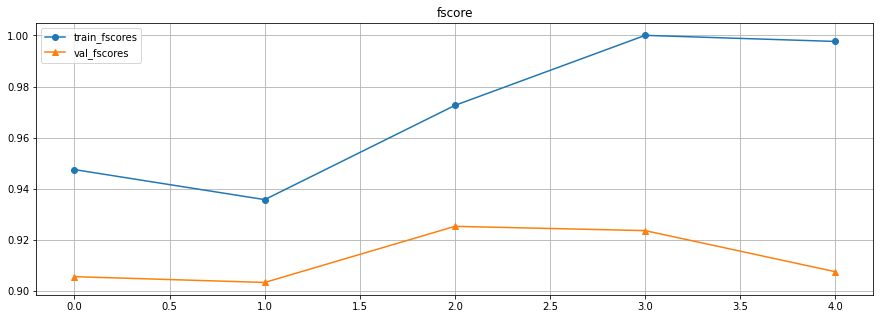

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.plot(train_fscores, '-o', label='train_fscores')
plt.plot(val_fscores, '-^', label='val_fscores')
plt.title('fscore')
plt.legend()
plt.grid()


plt.show()

# 結果の確認

今回は学習データの上位10個が正常に予測できていることを確認します。

In [22]:
# 最初のデータの出力を確認する
test_data = TrainData(train_df[:10],'test')

# DataLoaderを取得する
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

100%|██████████| 10/10 [00:00<00:00, 58.40it/s]


配列の最も大きいものが予測値となります。

In [ ]:
 for batch in test_loader:
    input_ids = batch[0].to(device)
    out = net(input_ids)
    print(out)

category_idと予測値が同じになることを確認してください。

In [ ]:
train_df[:10]